In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from IPython.display import Audio
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tqdm

import random
import glob
import os
import ast

import sys
sys.path.append("..")
import utils

In [2]:
RANDOM_SEED = 21

# Set seed for experiment reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
is_in_kaggle_env = utils.get_is_in_kaggle_env()

data_path = '/kaggle/input/birdclef-2023' if is_in_kaggle_env else '../data'

device = 'cpu' if is_in_kaggle_env else utils.determine_device()

if not is_in_kaggle_env and not os.path.exists('../data'):
    print("Downloading data...")
    !kaggle competitions download -c 'birdclef-2023'
    !mkdir ../data
    !unzip -q birdclef-2023.zip -d ../data
    !rm birdclef-2023.zip

df_metadata_csv = pd.read_csv(f"{data_path}/train_metadata.csv")

audio_data_dir = f"{data_path}/train_audio/"

We are running code on Localhost
We are using device: mps


In [4]:
df_metadata_csv.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg


In [5]:
df_metadata_csv[df_metadata_csv['filename'].str.contains("XC321277")]

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
13623,tafpri1,[],['call'],-33.6302,26.5732,Prinia subflava,Tawny-flanked Prinia,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/321277,tafpri1/XC321277.ogg


In [6]:
audio_path = df_metadata_csv.iloc[0, 11]
print(f"Audio path: {audio_path}")

primary_label = df_metadata_csv.iloc[0, 0]
print(f"Primary label: {primary_label}")

secondary_labels = df_metadata_csv.iloc[0, 1]
print(f"Secondary labels: {secondary_labels}")

file_id = audio_path.split('/')[-1].split('.')[0]
print(f"File ID: {file_id}")

print(f"df length: {len(df_metadata_csv)}")

Audio path: abethr1/XC128013.ogg
Primary label: abethr1
Secondary labels: []
File ID: XC128013
df length: 16941


In [7]:
df_metadata_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16941 entries, 0 to 16940
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     16941 non-null  object 
 1   secondary_labels  16941 non-null  object 
 2   type              16941 non-null  object 
 3   latitude          16714 non-null  float64
 4   longitude         16714 non-null  float64
 5   scientific_name   16941 non-null  object 
 6   common_name       16941 non-null  object 
 7   author            16941 non-null  object 
 8   license           16941 non-null  object 
 9   rating            16941 non-null  float64
 10  url               16941 non-null  object 
 11  filename          16941 non-null  object 
dtypes: float64(3), object(9)
memory usage: 1.6+ MB


In [8]:
class_counts = df_metadata_csv["primary_label"].value_counts()

two_or_less_samples_rows = df_metadata_csv[df_metadata_csv["primary_label"].isin(class_counts[class_counts < 3].index)]

print(f"Number of unique classes with less than 2 samples: {len(two_or_less_samples_rows['primary_label'].unique())}")
print(f"Number of rows with less than 2 samples: {len(two_or_less_samples_rows)}")
print(f"Primary labels with less than 2 samples: {two_or_less_samples_rows['primary_label'].unique()}")

Number of unique classes with less than 2 samples: 10
Number of rows with less than 2 samples: 13
Primary labels with less than 2 samples: ['afpkin1' 'brcwea1' 'brtcha1' 'crefra2' 'golher1' 'lotcor1' 'rehblu1'
 'whctur2' 'whhsaw1' 'yebsto1']


In [9]:
# Drop rows with primary_label that have two or less samples
print(f"Number of rows before dropping: {len(df_metadata_csv)}")
df_metadata_csv = df_metadata_csv[~df_metadata_csv["primary_label"].isin(class_counts[class_counts < 3].index)]
print(f"Number of rows after dropping: {len(df_metadata_csv)}")

Number of rows before dropping: 16941
Number of rows after dropping: 16928


In [10]:
# go through each row of a 10% random sample of train_df, get the audio file length, and add it to a list, show the progress using tqdm

audio_lengths_s = []
for i, row in tqdm.tqdm(df_metadata_csv.sample(frac=0.1).iterrows(), total=int(len(df_metadata_csv) * 0.1)):
    audio_path = row["filename"]
    audio_path = f"{audio_data_dir}/{audio_path}"
    audio, sr = librosa.load(audio_path)
    audio_lengths_s.append(len(audio) / sr)

1693it [01:07, 24.95it/s]                          


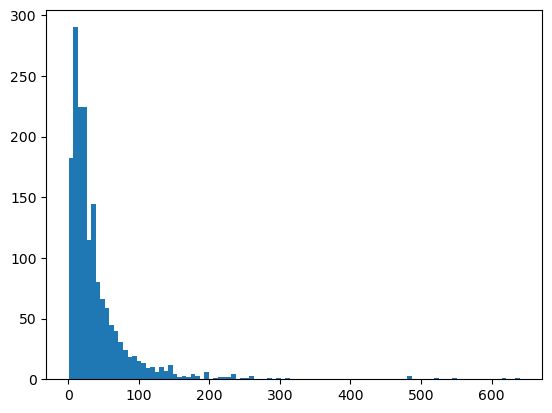

In [11]:
# plot the audio lengths
plt.hist(audio_lengths_s, bins=100)
plt.show()

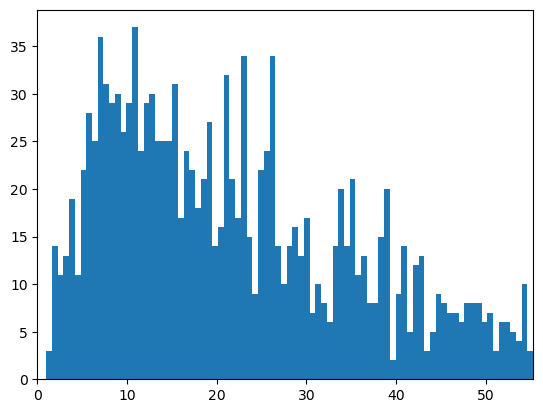

In [12]:
# plot the audio lengths as histogram until 80th percentile
plt.hist(audio_lengths_s, bins=1000)
plt.xlim(0, np.percentile(audio_lengths_s, 80))
plt.show()

In [13]:
max(audio_lengths_s), min(audio_lengths_s), np.percentile(audio_lengths_s, 80)

(640.0522902494331, 0.9665759637188208, 55.33222675736962)

In [14]:
np.mean(audio_lengths_s), np.median(audio_lengths_s)

(39.524182005938826, 24.790249433106577)

In [15]:
# Get unique classes
unique_primary_classes = df_metadata_csv.primary_label.unique()

secondary_classes = df_metadata_csv.secondary_labels.tolist()
unique_secondary_classes = set()
for class_list_str in secondary_classes:
    class_list = ast.literal_eval(class_list_str)
    for c in class_list:
        unique_secondary_classes.add(c)

classes = set(unique_primary_classes).union(unique_secondary_classes)
print(f"Number of classes: {len(classes)}")

classes_in_secondary_but_not_primary = unique_secondary_classes.difference(unique_primary_classes)
print(f"Number of classes in secondary but not primary: {len(classes_in_secondary_but_not_primary)}")

Number of classes: 257
Number of classes in secondary but not primary: 3


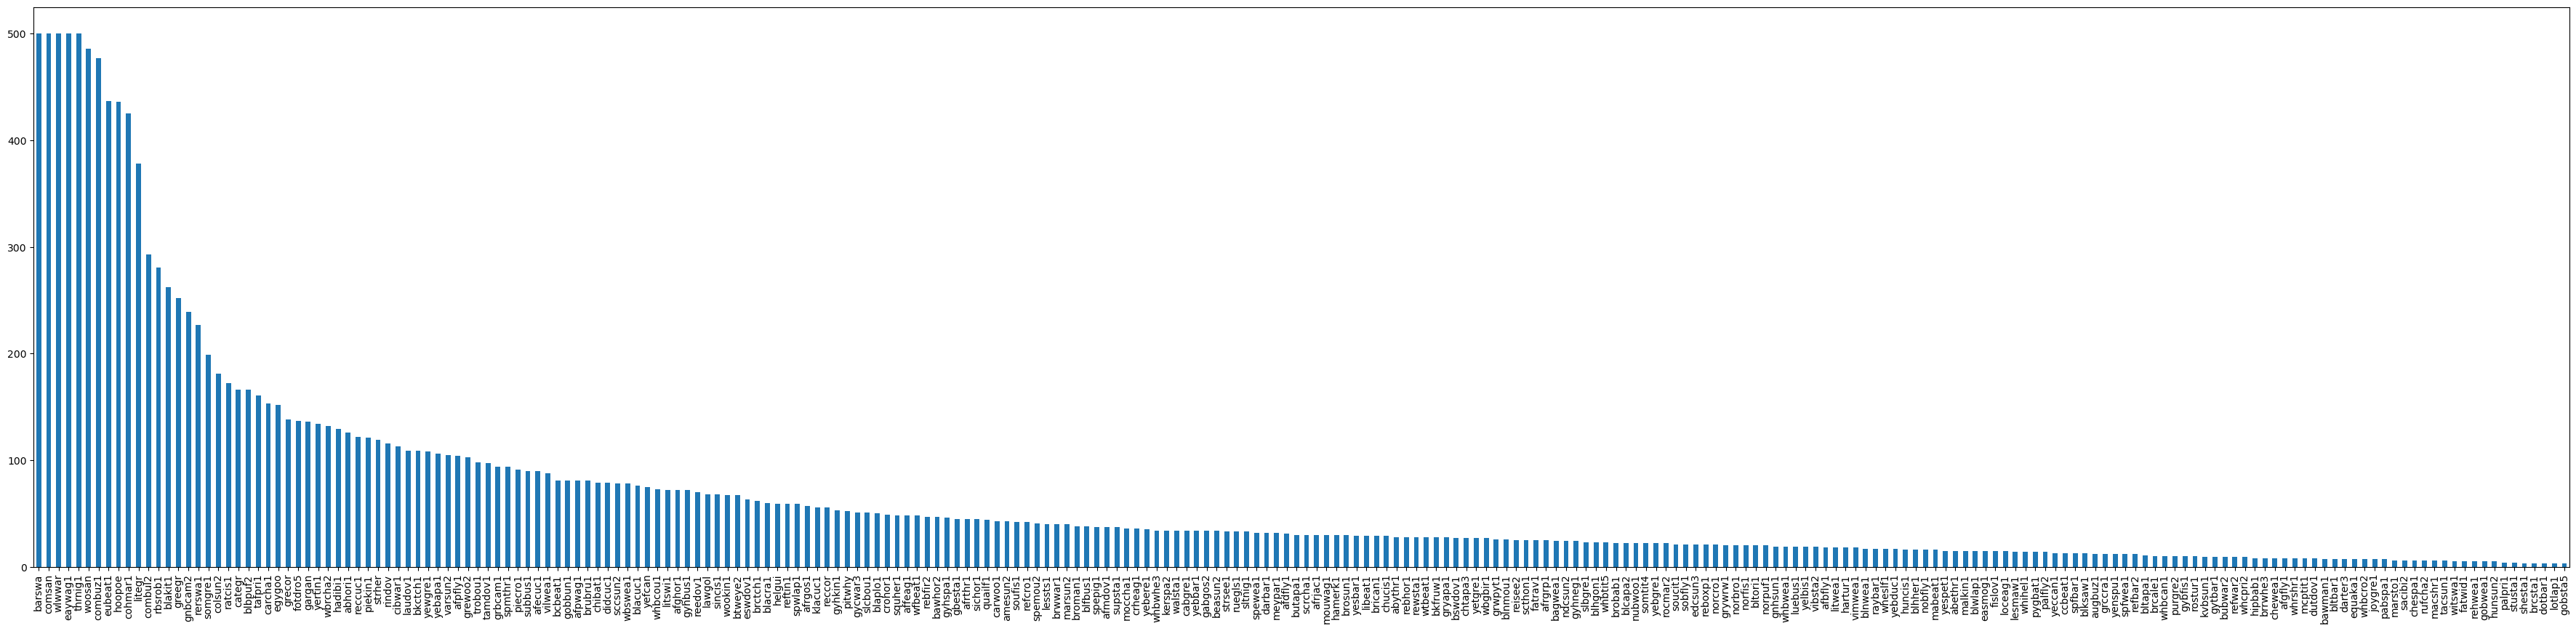

In [18]:
# Get class imbalance and plot it
class_counts = df_metadata_csv["primary_label"].value_counts()
class_counts.plot(kind='bar', figsize=(45, 10))
plt.show()